In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from PrettyPrint import PrettyPrintTree
from colorama import Back
from tqdm import tqdm

In [2]:
def call_put_prices(S, K, r, t, sigma, option_type):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * t) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * t) * norm.cdf(-d2) - S * norm.cdf(-d1)

In [3]:
K = 500
Put = 3
S = 493
r = .01
T = 3

Call + Put = S - K * exp(-r * T)

Call = S - K * exp(-r * T) - Put

In [4]:
Call = S - K * np.exp(-r * T) - Put

In [5]:
print(f'Цена Европейского call оциона - {Call:.2f}')

Цена Европейского call оциона - 4.78


Цена Американского call опциона = 4.78

In [16]:
def dx(fn, x, delta=0.0001):
    return (fn(S, K, r, T, x+delta, 'put') - fn(S, K, r, T, x, 'put'))/delta

def solve(fn, value, x=0.5, maxtries=1000, maxerr=0.001):
    for tries in range(maxtries):
        err = fn(S, K, r, T, x, 'put') - value
        if abs(err) < maxerr:
            return x
        slope = dx(fn, x)
        x -= err/slope
    raise ValueError('no solution found')

In [17]:
approximate_sigma = solve(call_put_prices, 3)
print(f'Приближенная сигма {approximate_sigma:.3f}')

Приближенная сигма 0.018


In [20]:
am_option_price = calculate_option_price(S, K, approximate_sigma, T, r, 2000, t='call', c_t='am')

In [21]:
print(f'Цена америкинского call оциона по биноминальной модели - {am_option_price:.3f}')

Цена америкинского call оциона по биноминальной модели - 10.776


### Биномильная модель

In [6]:
class Node:
    def __init__(self, data: float, left=None, right=None, period=None):
        self.data = data
        self.left = left
        self.right = right
        self.period = period
        self.p = None # Prob for left turn
    
    def __str__(self):
        return f'{self.data:.3f}'

class Model:
    
    def __init__(self, N: int, T: int, S: float, sigma: float, r: float):
        self.N = N + 1
        self.T = T
        self.sigma = sigma
        self.r = r
        self.root = Node(S, T, period=0)
        
        
        self._generate_layer(self.root, 1)
    
    def _generate_layer(self, curr_node: Node, step: int):
        if step == self.N:
            return None
        S = curr_node.data
        dt = self.T / self.N
        u = np.exp(self.sigma * np.sqrt(dt))
        d = np.exp(-self.sigma * np.sqrt(dt))
        
        
        curr_node.left = Node(S * u, period=step * (dt))
        curr_node.right = Node(S / u, period=step * (dt))
        self._generate_layer(curr_node.left, step + 1)
        self._generate_layer(curr_node.right, step + 1)
        
    def traverseInorder(self, root):
        result = []
        if root is not None:
            result.append(root)
            result.extend(self.traverseInorder(root.left))
            result.extend(self.traverseInorder(root.right))
        return result

In [7]:
model = Model(3, 4, 500, 0.05, 0.01)
root = model.root

In [8]:
pt = PrettyPrintTree(
    lambda node: [node.left, node.right],
    lambda node: node,
    lambda node: node.p,
    max_depth=model.N,
    border=True,
    color=Back.WHITE,
    start_message=lambda node: f'Биноминальная модель'
)

In [9]:
pt(root, orientation=PrettyPrintTree.VERTICAL)

Биноминальная модель
                                       │
                                       │
                                   [500.000]
                   ┌───────────────────┴───────────────────┐
                   │                                       │
                   │                                       │
               [525.636]                               [475.615]
         ┌─────────┴─────────┐                   ┌─────────┴─────────┐
         │                   │                   │                   │
         │                   │                   │                   │
     [552.585]           [500.000]           [500.000]           [452.419]
    ┌────┴────┐         ┌────┴────┐         ┌────┴────┐         ┌────┴────┐
    │         │         │         │         │         │         │         │
    │         │         │         │         │         │         │         │
[580.917] [525.636] [525.636] [475.615] [525.636] [475.615] [475.615] [430.354]
        

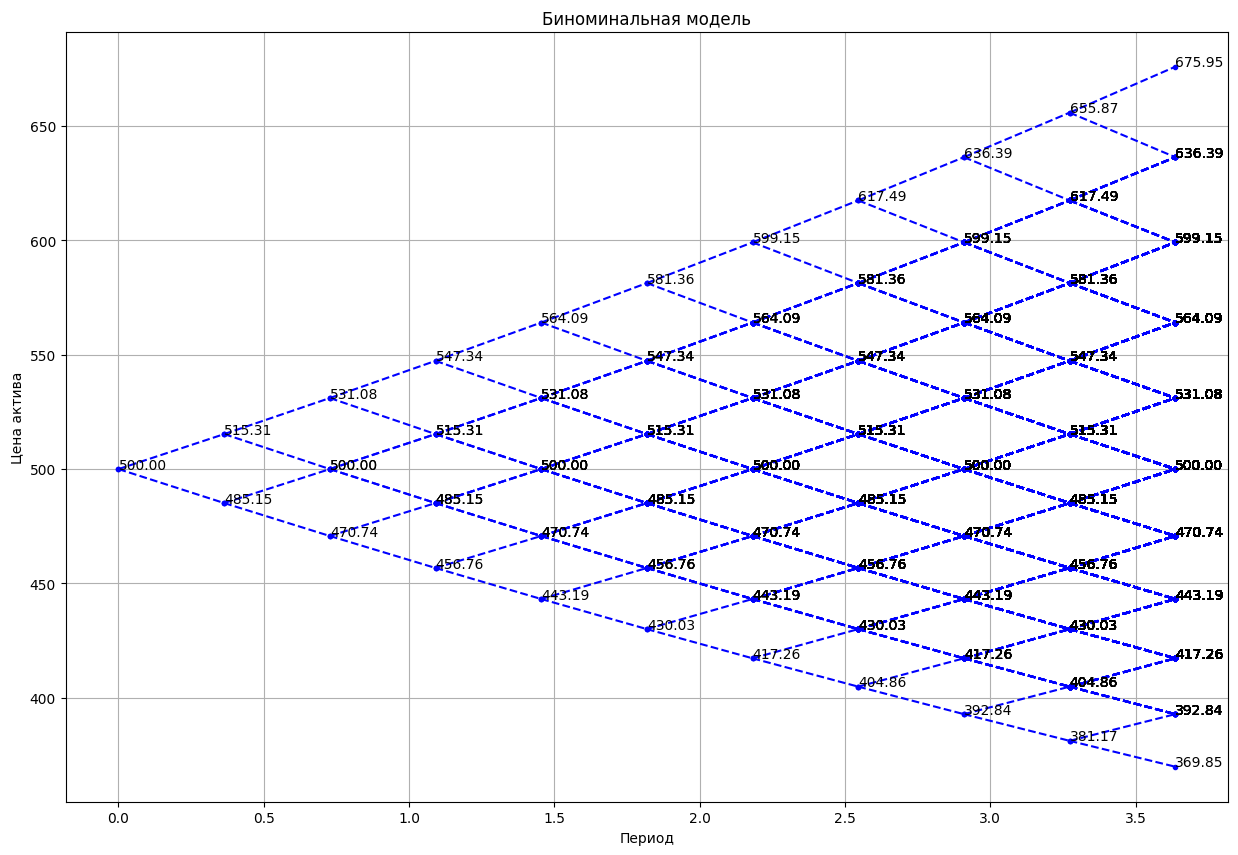

In [10]:
result = Model(10, 4, 500, 0.05, 0.01)
root = result.root

plt.figure(figsize=(15, 10))
plt.grid()
plt.title('Биноминальная модель')
plt.xlabel('Период')
plt.ylabel('Цена актива')
dot_x = []
dot_y = []
for node in result.traverseInorder(result.root):
    if node.left is not None:
        plt.plot((node.period, node.left.period),(node.data, node.left.data), '--.', c='blue')
        plt.plot((node.period, node.right.period),(node.data, node.right.data), '--.', c='blue')
        plt.text(node.period, node.data, f'{node.data:.2f}')
    else:
        plt.text(node.period, node.data, f'{node.data:.2f}')

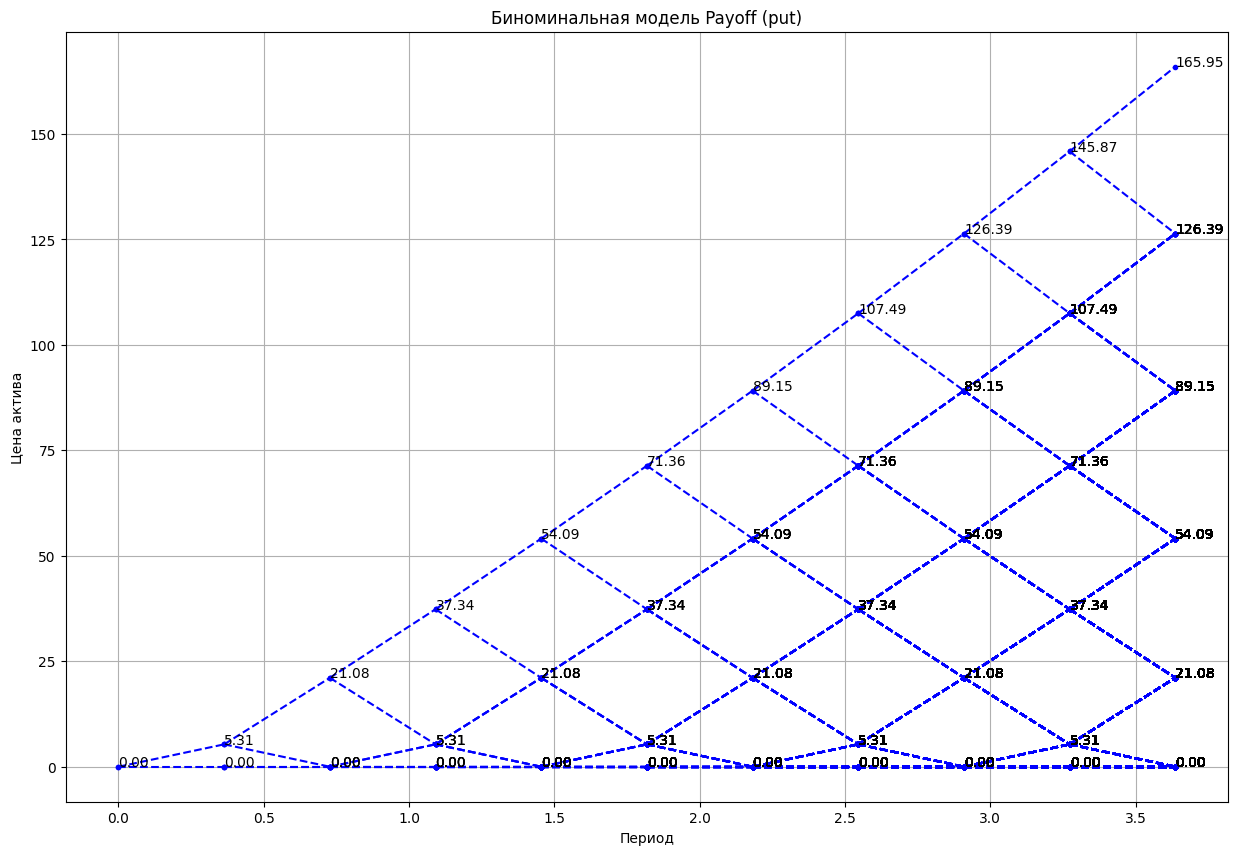

In [11]:
K = 510

plt.figure(figsize=(15, 10))
plt.grid()
plt.title('Биноминальная модель Payoff (put)')
plt.xlabel('Период')
plt.ylabel('Цена актива')
for node in result.traverseInorder(result.root):
    if node.left is not None:
        plt.plot((node.period, node.left.period),(max(node.data - K, 0), max(node.left.data - K, 0)), '--.', c='blue')
        plt.plot((node.period, node.right.period),(max(node.data - K, 0), max(node.right.data - K, 0)), '--.', c='blue')
        plt.text(node.period, max(node.data - K, 0), f'{max(node.data - K, 0):.2f}')
    else:
        plt.text(node.period, max(node.data - K, 0), f'{max(node.data - K, 0):.2f}')

In [12]:
s = 500
X = 510
T = 4
r = .05
SIGMA = .05
N = 10

$$
    S_{i,j} = S_{0}u^jd^{i-j}
$$

In [6]:
u_f = lambda sigma, dt: np.exp(sigma * np.sqrt(dt))
d_f = lambda sigma, dt: np.exp(-sigma * np.sqrt(dt))
p_f = lambda sigma, r, dt: (np.exp(r * dt) - d_f(sigma, dt)) / (u_f(sigma, dt) - d_f(sigma, dt))

def calculate_option_price(s, x, sigma, T, r, N, t='call', c_t='eu'):
    dt = T / N
    u = u_f(sigma, dt)
    d = d_f(sigma, dt)
    p = p_f(sigma, r, dt)
    
    # Для последнего слоя i = max
    i = N
    S = [s * (u ** j) * (d ** (i - j))
         for j in range(N + 1)]
    if t == 'call':
        C = [max(0, S[j] - x) for j in range(N + 1)]
    else:
        C = [max(0, x - S[j]) for j in range(N + 1)]
    # Обратный проход по дереву
    if c_t == 'eu':
        for i in range(N, 0, -1):
            for j in range(i):
                C[j] = np.exp(-r * dt) * (p * C[j + 1] + (1 - p) * C[j])
    else:
        for i in range(N - 1, -1, -1):
            for j in range(i + 1):
                V = np.exp(-r * dt) * (p * C[j + 1] + (1 - p) * C[j])
                S =  s * u ** j * d ** (i - j)
                if t == 'call':
                    C[j] = max(V, S - x)
                else:
                    C[j] = max(V, x - S)
            
    return C[0]            

In [23]:
S = 70
X = 70
T = 2
r = 0.05
sigma = 0.4
N = (20, 400)

In [24]:
option_prices = []
for n in tqdm(range(N[0], N[1] + 1)):
    option_prices.append(calculate_option_price(S, X, sigma, T, r, n, t='put', c_t='eu'))

100%|████████████████████████████████████████████████████████████████████████████████| 381/381 [00:19<00:00, 19.31it/s]


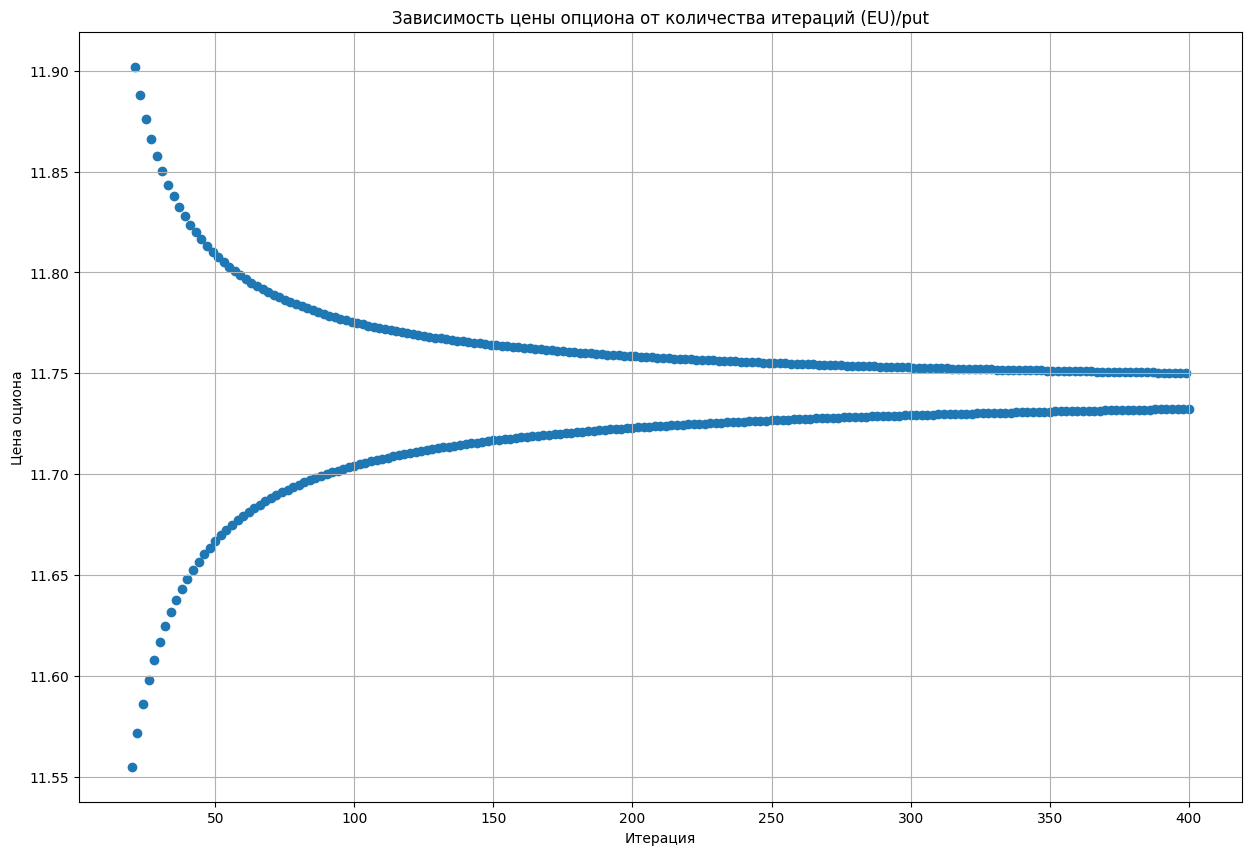

In [25]:
plt.figure(figsize=(15, 10))
plt.title('Зависимость цены опциона от количества итераций (EU)/put')
plt.scatter(list(range(N[0], N[1] + 1)), option_prices, label='Цена опциона')
plt.xlabel('Итерация')
plt.ylabel('Цена оциона')
plt.grid()

In [17]:
print(f'Цена по формуле Блека-Шоулза - {call_put_prices(S, X, r, T, sigma, "put"):.3f}')
print(f'Цена по биноминальной модели на 400 итерации - {option_prices[-1]:.3f}')

Цена по формуле Блека-Шоулза - 11.742
Цена по биноминальной модели на 400 итерации - 11.732


In [18]:
from concurrent.futures import ThreadPoolExecutor, as_completed

am_option_prices = []
with ThreadPoolExecutor(max_workers=6) as executor:
    N = (1, 2000)
    futures = []
    for n in range(N[0], N[1] + 1):
        futures.append(executor.submit(calculate_option_price, S, X, sigma, T, r, n, t='put', c_t='am'))
    
                       
    for future in tqdm(as_completed(futures), total=len(futures)):
        am_option_prices.append(future.result())

100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [1:00:35<00:00,  1.82s/it]


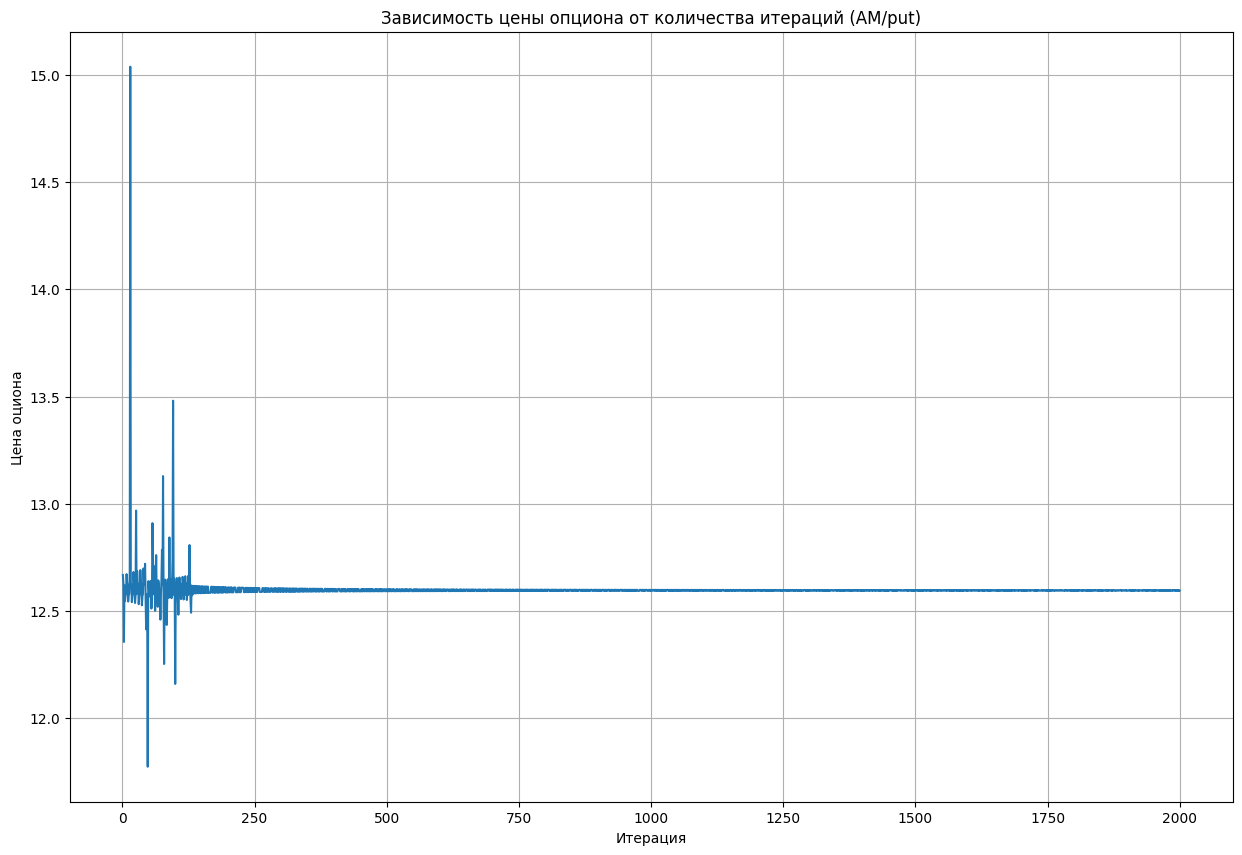

In [23]:
plt.figure(figsize=(15, 10))
plt.title('Зависимость цены опциона от количества итераций (AM/put)')
plt.plot(list(range(1, 2001)), am_option_prices, label='Цена опциона')
plt.xlabel('Итерация')
plt.ylabel('Цена оциона')
plt.grid()

In [24]:
print(f'Американский опцион N=2000 - {am_option_prices[-1]:.2f}')

Американский опцион N=2000 - 12.59


In [25]:
N = (20, 400)
X = 68
option_prices = []
for n in tqdm(range(N[0], N[1] + 1)):
    option_prices.append(calculate_option_price(S, X, sigma, T, r, n, t='call', c_t='eu'))

100%|████████████████████████████████████████████████████████████████████████████████| 381/381 [00:16<00:00, 22.92it/s]


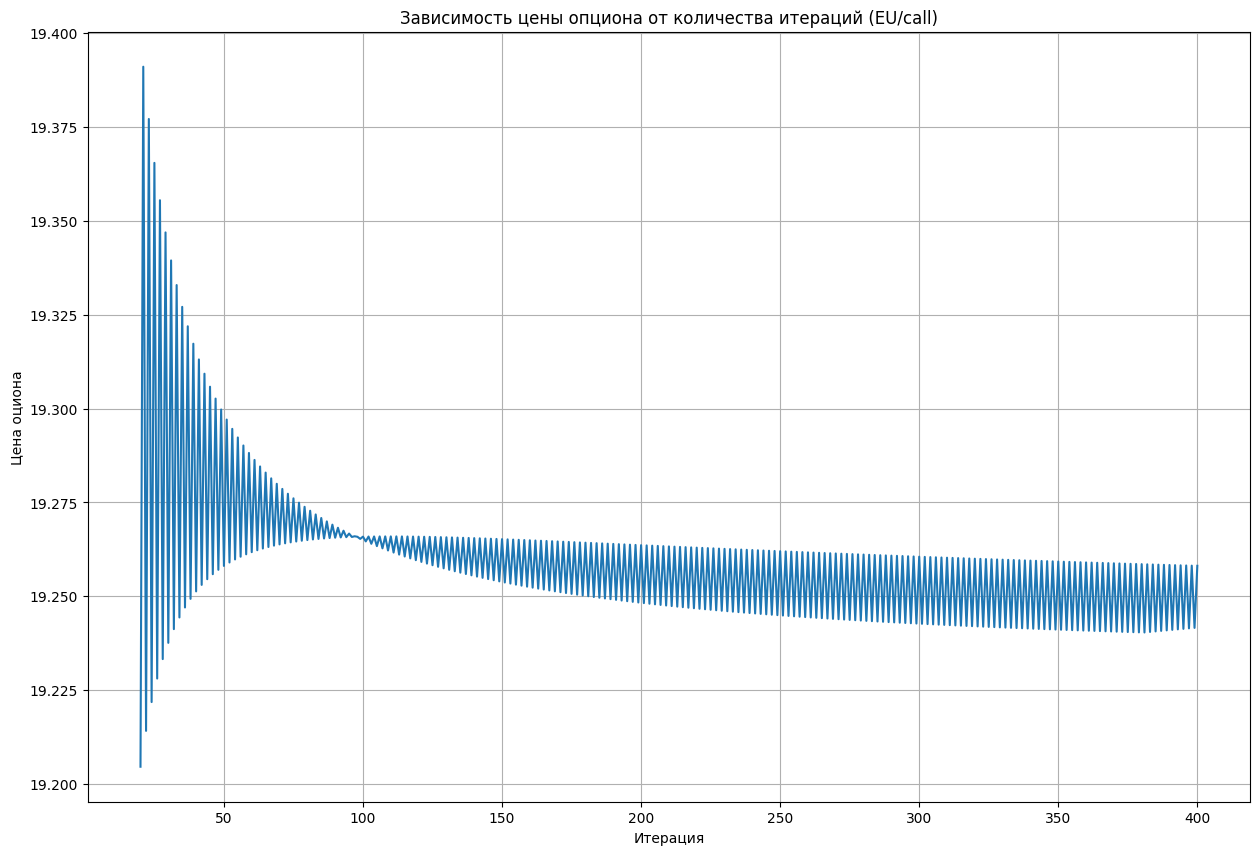

In [26]:
plt.figure(figsize=(15, 10))
plt.title('Зависимость цены опциона от количества итераций (EU/call)')
plt.plot(list(range(N[0], N[1] + 1)), option_prices, label='Цена опциона')
plt.xlabel('Итерация')
plt.ylabel('Цена оциона')
plt.grid()

In [27]:
print(f'Цена по формуле Блека-Шоулза - {call_put_prices(S, X, r, T, sigma, "call"):.3f}')
print(f'Цена по биноминальной модели на 400 итерации - {option_prices[-1]:.3f}')

Цена по формуле Блека-Шоулза - 19.250
Цена по биноминальной модели на 400 итерации - 19.258
